<a href="https://colab.research.google.com/github/plaban1981/text_to_video/blob/main/Text_to_Image_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/spaces/PAIR/Text2Video-Zero

https://huggingface.co/spaces/kadirnar/Tune-A-Video/blob/main/tuneavideo/util.py

In [4]:
! pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.1 MB/s eta 0:00:00


In [5]:
! pip install -qU accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 6.4 MB/s eta 0:00:00


In [6]:
! pip install -qU diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 14.1 MB/s eta 0:00:00


In [1]:
import transformers
transformers.__version__

'4.28.0'

In [7]:
!pip install -q imageio[ffmpeg]==2.26.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.6 MB/s eta 0:00:00


In [2]:
!pip install -q tomesd

In [14]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.0 MB/s eta 0:00:00


In [16]:
!pip install -q kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 12.7 MB/s eta 0:00:00


In [19]:
!pip install -q annotator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00


In [2]:
%%writefile requirements.txt
accelerate==0.17.1
git+https://github.com/huggingface/diffusers@9dc8444
gradio==3.23.0
huggingface-hub==0.13.3
imageio[ffmpeg]==2.26.1
torch==2.0.0
torchvision==0.15.1
transformers==4.27.2

Writing requirements.txt


## Import Libraries

In [4]:
import os
import random
import tempfile

import imageio
import numpy as np
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

In [5]:
MAX_NUM_FRAMES = 200
DEFAULT_NUM_FRAMES = 16

pipe = DiffusionPipeline.from_pretrained('damo-vilab/text-to-video-ms-1.7b',
                                         torch_dtype=torch.float16,
                                         variant='fp16')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

##Save the pretrained model

In [6]:
pipe.save_pretrained("text_to_image")

## Helper Functions

In [27]:
def to_video(frames: list[np.ndarray], fps: int) -> str:
    out_file = tempfile.NamedTemporaryFile(suffix='.mp4', delete=False)
    writer = imageio.get_writer(out_file.name, format='FFMPEG', fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    return out_file.name


def generate(prompt: str,negative_prompt: str,seed: int, num_frames: int,
             num_inference_steps: int) -> str:
    if seed == -1:
        seed = random.randint(0, 1000000)
    generator = torch.Generator().manual_seed(seed)
    frames = pipe(prompt,
                  negative_prompt=negative_prompt,
                  num_inference_steps=num_inference_steps,
                  num_frames=num_frames,
                  generator=generator).frames
    return to_video(frames, 8)

In [ ]:
examples = [
    ['An astronaut riding a horse.', 0, 16, 25],
    ['A panda eating bamboo on a rock.', 0, 16, 25],
    ['Spiderman is surfing.', 0, 16, 25],
]

In [47]:
video_file = generate('A high quality face closeup of a Fashion model walking the ramp wearing bright coloured clothes.',
                      "low_quality"
                      42,
                      32,
                      50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
video_file

'/tmp/tmp51cnzilx.mp4'

In [48]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path

#
# Show video
mp4 = open(video_file,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [34]:
import moviepy
from moviepy.editor import *
moviepy.editor.ipython_display(video_file)

In [50]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video

pipe = DiffusionPipeline.from_pretrained("dreamlike-art/dreamlike-photoreal-2.0", torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

prompt = "Spiderman is surfing"
video_frames = pipe(prompt, num_inference_steps=25)
#video_path = export_to_video(video_frames)


  0%|          | 0/25 [00:00<?, ?it/s]

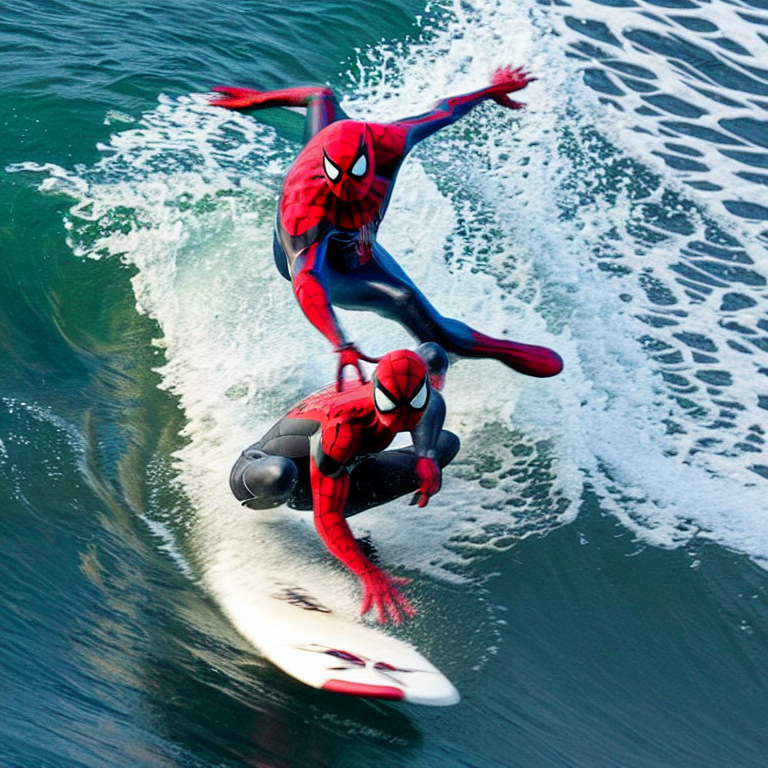

In [54]:
display(video_frames.images[0])

## Text-to-video : dreamlike-art/dreamlike-photoreal-2.0

https://pharmapsychotic.com/tools.html

In [18]:
%%writefile requirements.txt
accelerate==0.16.0
addict==2.4.0
albumentations==1.3.0
basicsr==1.4.2
decord==0.6.0
diffusers==0.14.0
einops==0.6.0
gradio==3.23.0
kornia==0.6
imageio==2.9.0
imageio-ffmpeg==0.4.2
invisible-watermark>=0.1.5
moviepy==1.0.3
numpy==1.24.1
omegaconf==2.3.0
open_clip_torch==2.16.0
opencv_python==4.7.0.72
opencv-contrib-python==4.7.0.72
Pillow==9.4.0
pytorch_lightning==1.5.0
prettytable==3.6.0
scikit_image==0.19.3
scipy==1.10.1
tensorboardX==2.6
torch==1.13.1
torchvision==0.14.1
torchmetrics==0.6.0
tqdm==4.64.1
timm==0.6.12
transformers==4.26.0
test-tube>=0.7.5
webdataset==0.2.5
yapf==0.32.0
safetensors==0.2.7
beautifulsoup4
bs4
tomesd

Overwriting requirements.txt


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from diffusers import StableDiffusionPipeline
import torch
from dataclasses import dataclass
from typing import Callable, List, Optional, Union
import numpy as np
from diffusers.utils import deprecate, logging, BaseOutput
from einops import rearrange, repeat
from torch.nn.functional import grid_sample
import torchvision.transforms as T
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
import PIL
from PIL import Image
from kornia.morphology import dilation


@dataclass
class TextToVideoPipelineOutput(BaseOutput):
    # videos: Union[torch.Tensor, np.ndarray]
    # code: Union[torch.Tensor, np.ndarray]
    images: Union[List[PIL.Image.Image], np.ndarray]
    nsfw_content_detected: Optional[List[bool]]


def coords_grid(batch, ht, wd, device):
    # Adapted from https://github.com/princeton-vl/RAFT/blob/master/core/utils/utils.py
    coords = torch.meshgrid(torch.arange(
        ht, device=device), torch.arange(wd, device=device))
    coords = torch.stack(coords[::-1], dim=0).float()
    return coords[None].repeat(batch, 1, 1, 1)


class TextToVideoPipeline(StableDiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__(vae, text_encoder, tokenizer, unet, scheduler,
                         safety_checker, feature_extractor, requires_safety_checker)

    def DDPM_forward(self, x0, t0, tMax, generator, device, shape, text_embeddings):
        rand_device = "cpu" if device.type == "mps" else device

        if x0 is None:
            return torch.randn(shape, generator=generator, device=rand_device, dtype=text_embeddings.dtype).to(device)
        else:
            eps = torch.randn(x0.shape, dtype=text_embeddings.dtype, generator=generator,
                              device=rand_device)
            alpha_vec = torch.prod(self.scheduler.alphas[t0:tMax])

            xt = torch.sqrt(alpha_vec) * x0 + \
                torch.sqrt(1-alpha_vec) * eps
            return xt

    def prepare_latents(self, batch_size, num_channels_latents, video_length, height, width, dtype, device, generator, latents=None):
        shape = (batch_size, num_channels_latents, video_length, height //
                 self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            rand_device = "cpu" if device.type == "mps" else device

            if isinstance(generator, list):
                shape = (1,) + shape[1:]
                latents = [
                    torch.randn(
                        shape, generator=generator[i], device=rand_device, dtype=dtype)
                    for i in range(batch_size)
                ]
                latents = torch.cat(latents, dim=0).to(device)
            else:
                latents = torch.randn(
                    shape, generator=generator, device=rand_device, dtype=dtype).to(device)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def warp_latents_independently(self, latents, reference_flow):
        _, _, H, W = reference_flow.size()
        b, _, f, h, w = latents.size()
        assert b == 1
        coords0 = coords_grid(f, H, W, device=latents.device).to(latents.dtype)

        coords_t0 = coords0 + reference_flow
        coords_t0[:, 0] /= W
        coords_t0[:, 1] /= H

        coords_t0 = coords_t0 * 2.0 - 1.0

        coords_t0 = T.Resize((h, w))(coords_t0)

        coords_t0 = rearrange(coords_t0, 'f c h w -> f h w c')

        latents_0 = rearrange(latents[0], 'c f h w -> f  c  h w')
        warped = grid_sample(latents_0, coords_t0,
                             mode='nearest', padding_mode='reflection')

        warped = rearrange(warped, '(b f) c h w -> b c f h w', f=f)
        return warped

    def DDIM_backward(self, num_inference_steps, timesteps, skip_t, t0, t1, do_classifier_free_guidance, null_embs, text_embeddings, latents_local,
                      latents_dtype, guidance_scale, guidance_stop_step, callback, callback_steps, extra_step_kwargs, num_warmup_steps):
        entered = False

        f = latents_local.shape[2]

        latents_local = rearrange(latents_local, "b c f w h -> (b f) c w h")

        latents = latents_local.detach().clone()
        x_t0_1 = None
        x_t1_1 = None

        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if t > skip_t:
                    continue
                else:
                    if not entered:
                        print(
                            f"Continue DDIM with i = {i}, t = {t}, latent = {latents.shape}, device = {latents.device}, type = {latents.dtype}")
                        entered = True

                latents = latents.detach()
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat(
                    [latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t)

                # predict the noise residual
                with torch.no_grad():
                    if null_embs is not None:
                        text_embeddings[0] = null_embs[i][0]
                    te = torch.cat([repeat(text_embeddings[0, :, :], "c k -> f c k", f=f),
                                   repeat(text_embeddings[1, :, :], "c k -> f c k", f=f)])
                    noise_pred = self.unet(
                        latent_model_input, t, encoder_hidden_states=te).sample.to(dtype=latents_dtype)

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(
                        2)
                    noise_pred = noise_pred_uncond + guidance_scale * \
                        (noise_pred_text - noise_pred_uncond)

                if i >= guidance_stop_step * len(timesteps):
                    alpha = 0
                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs).prev_sample
                # latents = latents - alpha * grads / (torch.norm(grads) + 1e-10)
                # call the callback, if provided

                if i < len(timesteps)-1 and timesteps[i+1] == t0:
                    x_t0_1 = latents.detach().clone()
                    print(f"latent t0 found at i = {i}, t = {t}")
                elif i < len(timesteps)-1 and timesteps[i+1] == t1:
                    x_t1_1 = latents.detach().clone()
                    print(f"latent t1 found at i={i}, t = {t}")

                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        latents = rearrange(latents, "(b f) c w h -> b c f  w h", f=f)

        res = {"x0": latents.detach().clone()}
        if x_t0_1 is not None:
            x_t0_1 = rearrange(x_t0_1, "(b f) c w h -> b c f  w h", f=f)
            res["x_t0_1"] = x_t0_1.detach().clone()
        if x_t1_1 is not None:
            x_t1_1 = rearrange(x_t1_1, "(b f) c w h -> b c f  w h", f=f)
            res["x_t1_1"] = x_t1_1.detach().clone()
        return res

    def decode_latents(self, latents):
        video_length = latents.shape[2]
        latents = 1 / 0.18215 * latents
        latents = rearrange(latents, "b c f h w -> (b f) c h w")
        video = self.vae.decode(latents).sample
        video = rearrange(video, "(b f) c h w -> b c f h w", f=video_length)
        video = (video / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        video = video.detach().cpu()
        return video

    def create_motion_field(self, motion_field_strength_x, motion_field_strength_y, frame_ids, video_length, latents):

        reference_flow = torch.zeros(
            (video_length-1, 2, 512, 512), device=latents.device, dtype=latents.dtype)
        for fr_idx, frame_id in enumerate(frame_ids):
            reference_flow[fr_idx, 0, :,
                           :] = motion_field_strength_x*(frame_id)
            reference_flow[fr_idx, 1, :,
                           :] = motion_field_strength_y*(frame_id)
        return reference_flow

    def create_motion_field_and_warp_latents(self, motion_field_strength_x, motion_field_strength_y, frame_ids, video_length, latents):

        motion_field = self.create_motion_field(motion_field_strength_x=motion_field_strength_x,
                                                motion_field_strength_y=motion_field_strength_y, latents=latents, video_length=video_length, frame_ids=frame_ids)
        for idx, latent in enumerate(latents):
            latents[idx] = self.warp_latents_independently(
                latent[None], motion_field)
        return motion_field, latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        video_length: Optional[int],
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        guidance_stop_step: float = 0.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_videos_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator,
                                  List[torch.Generator]]] = None,
        xT: Optional[torch.FloatTensor] = None,
        null_embs: Optional[torch.FloatTensor] = None,
        motion_field_strength_x: float = 12,
        motion_field_strength_y: float = 12,
        output_type: Optional[str] = "tensor",
        return_dict: bool = True,
        callback: Optional[Callable[[
            int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        use_motion_field: bool = True,
        smooth_bg: bool = False,
        smooth_bg_strength: float = 0.4,
        t0: int = 44,
        t1: int = 47,
        **kwargs,
    ):
        frame_ids = kwargs.pop("frame_ids", list(range(video_length)))
        assert t0 < t1
        assert num_videos_per_prompt == 1
        assert isinstance(prompt, list) and len(prompt) > 0
        assert isinstance(negative_prompt, list) or negative_prompt is None

        prompt_types = [prompt, negative_prompt]

        for idx, prompt_type in enumerate(prompt_types):
            prompt_template = None
            for prompt in prompt_type:
                if prompt_template is None:
                    prompt_template = prompt
                else:
                    assert prompt == prompt_template
            if prompt_types[idx] is not None:
                prompt_types[idx] = prompt_types[idx][0]
        prompt = prompt_types[0]
        negative_prompt = prompt_types[1]

        # Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # Check inputs. Raise error if not correct
        self.check_inputs(prompt, height, width, callback_steps)

        # Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt, device, num_videos_per_prompt, do_classifier_free_guidance, negative_prompt
        )

        # Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # print(f" Latent shape = {latents.shape}")

        # Prepare latent variables
        num_channels_latents = self.unet.in_channels

        xT = self.prepare_latents(
            batch_size * num_videos_per_prompt,
            num_channels_latents,
            1,
            height,
            width,
            text_embeddings.dtype,
            device,
            generator,
            xT,
        )
        dtype = xT.dtype

        # when motion field is not used, augment with random latent codes
        if use_motion_field:
            xT = xT[:, :, :1]
        else:
            if xT.shape[2] < video_length:
                xT_missing = self.prepare_latents(
                    batch_size * num_videos_per_prompt,
                    num_channels_latents,
                    video_length-xT.shape[2],
                    height,
                    width,
                    text_embeddings.dtype,
                    device,
                    generator,
                    None,
                )
                xT = torch.cat([xT, xT_missing], dim=2)

        xInit = xT.clone()

        timesteps_ddpm = [981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
                          701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
                          421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
                          141, 121, 101,  81,  61,  41,  21,   1]
        timesteps_ddpm.reverse()

        t0 = timesteps_ddpm[t0]
        t1 = timesteps_ddpm[t1]

        print(f"t0 = {t0} t1 = {t1}")
        x_t1_1 = None

        # Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)
        # Denoising loop
        num_warmup_steps = len(timesteps) - \
            num_inference_steps * self.scheduler.order

        shape = (batch_size, num_channels_latents, 1, height //
                 self.vae_scale_factor, width // self.vae_scale_factor)

        ddim_res = self.DDIM_backward(num_inference_steps=num_inference_steps, timesteps=timesteps, skip_t=1000, t0=t0, t1=t1, do_classifier_free_guidance=do_classifier_free_guidance,
                                      null_embs=null_embs, text_embeddings=text_embeddings, latents_local=xT, latents_dtype=dtype, guidance_scale=guidance_scale, guidance_stop_step=guidance_stop_step,
                                      callback=callback, callback_steps=callback_steps, extra_step_kwargs=extra_step_kwargs, num_warmup_steps=num_warmup_steps)

        x0 = ddim_res["x0"].detach()

        if "x_t0_1" in ddim_res:
            x_t0_1 = ddim_res["x_t0_1"].detach()
        if "x_t1_1" in ddim_res:
            x_t1_1 = ddim_res["x_t1_1"].detach()
        del ddim_res
        del xT
        if use_motion_field:
            del x0

            x_t0_k = x_t0_1[:, :, :1, :, :].repeat(1, 1, video_length-1, 1, 1)

            reference_flow, x_t0_k = self.create_motion_field_and_warp_latents(
                motion_field_strength_x=motion_field_strength_x, motion_field_strength_y=motion_field_strength_y, latents=x_t0_k, video_length=video_length, frame_ids=frame_ids[1:])

            # assuming t0=t1=1000, if t0 = 1000
            if t1 > t0:
                x_t1_k = self.DDPM_forward(
                    x0=x_t0_k, t0=t0, tMax=t1, device=device, shape=shape, text_embeddings=text_embeddings, generator=generator)
            else:
                x_t1_k = x_t0_k

            if x_t1_1 is None:
                raise Exception

            x_t1 = torch.cat([x_t1_1, x_t1_k], dim=2).clone().detach()

            ddim_res = self.DDIM_backward(num_inference_steps=num_inference_steps, timesteps=timesteps, skip_t=t1, t0=-1, t1=-1, do_classifier_free_guidance=do_classifier_free_guidance,
                                          null_embs=null_embs, text_embeddings=text_embeddings, latents_local=x_t1, latents_dtype=dtype, guidance_scale=guidance_scale,
                                          guidance_stop_step=guidance_stop_step, callback=callback, callback_steps=callback_steps, extra_step_kwargs=extra_step_kwargs, num_warmup_steps=num_warmup_steps)

            x0 = ddim_res["x0"].detach()
            del ddim_res
            del x_t1
            del x_t1_1
            del x_t1_k
        else:
            x_t1 = x_t1_1.clone()
            x_t1_1 = x_t1_1[:, :, :1, :, :].clone()
            x_t1_k = x_t1_1[:, :, 1:, :, :].clone()
            x_t0_k = x_t0_1[:, :, 1:, :, :].clone()
            x_t0_1 = x_t0_1[:, :, :1, :, :].clone()

        # smooth background
        if smooth_bg:
            h, w = x0.shape[3], x0.shape[4]
            M_FG = torch.zeros((batch_size, video_length, h, w),
                               device=x0.device).to(x0.dtype)
            for batch_idx, x0_b in enumerate(x0):
                z0_b = self.decode_latents(x0_b[None]).detach()
                z0_b = rearrange(z0_b[0], "c f h w -> f h w c")
                for frame_idx, z0_f in enumerate(z0_b):
                    z0_f = torch.round(
                        z0_f * 255).cpu().numpy().astype(np.uint8)
                    # apply SOD detection
                    m_f = torch.tensor(self.sod_model.process_data(
                        z0_f), device=x0.device).to(x0.dtype)
                    mask = T.Resize(
                        size=(h, w), interpolation=T.InterpolationMode.NEAREST)(m_f[None])
                    kernel = torch.ones(5, 5, device=x0.device, dtype=x0.dtype)
                    mask = dilation(mask[None].to(x0.device), kernel)[0]
                    M_FG[batch_idx, frame_idx, :, :] = mask

            x_t1_1_fg_masked = x_t1_1 * \
                (1 - repeat(M_FG[:, 0, :, :],
                            "b w h -> b c 1 w h", c=x_t1_1.shape[1]))

            x_t1_1_fg_masked_moved = []
            for batch_idx, x_t1_1_fg_masked_b in enumerate(x_t1_1_fg_masked):
                x_t1_fg_masked_b = x_t1_1_fg_masked_b.clone()

                x_t1_fg_masked_b = x_t1_fg_masked_b.repeat(
                    1, video_length-1, 1, 1)
                if use_motion_field:
                    x_t1_fg_masked_b = x_t1_fg_masked_b[None]
                    x_t1_fg_masked_b = self.warp_latents_independently(
                        x_t1_fg_masked_b, reference_flow)
                else:
                    x_t1_fg_masked_b = x_t1_fg_masked_b[None]

                x_t1_fg_masked_b = torch.cat(
                    [x_t1_1_fg_masked_b[None], x_t1_fg_masked_b], dim=2)
                x_t1_1_fg_masked_moved.append(x_t1_fg_masked_b)

            x_t1_1_fg_masked_moved = torch.cat(x_t1_1_fg_masked_moved, dim=0)

            M_FG_1 = M_FG[:, :1, :, :]

            M_FG_warped = []
            for batch_idx, m_fg_1_b in enumerate(M_FG_1):
                m_fg_1_b = m_fg_1_b[None, None]
                m_fg_b = m_fg_1_b.repeat(1, 1, video_length-1, 1, 1)
                if use_motion_field:
                    m_fg_b = self.warp_latents_independently(
                        m_fg_b.clone(), reference_flow)
                M_FG_warped.append(
                    torch.cat([m_fg_1_b[:1, 0], m_fg_b[:1, 0]], dim=1))

            M_FG_warped = torch.cat(M_FG_warped, dim=0)

            channels = x0.shape[1]

            M_BG = (1-M_FG) * (1 - M_FG_warped)
            M_BG = repeat(M_BG, "b f h w -> b c f h w", c=channels)
            a_convex = smooth_bg_strength

            latents = (1-M_BG) * x_t1 + M_BG * (a_convex *
                                                x_t1 + (1-a_convex) * x_t1_1_fg_masked_moved)

            ddim_res = self.DDIM_backward(num_inference_steps=num_inference_steps, timesteps=timesteps, skip_t=t1, t0=-1, t1=-1, do_classifier_free_guidance=do_classifier_free_guidance,
                                          null_embs=null_embs, text_embeddings=text_embeddings, latents_local=latents, latents_dtype=dtype, guidance_scale=guidance_scale,
                                          guidance_stop_step=guidance_stop_step, callback=callback, callback_steps=callback_steps, extra_step_kwargs=extra_step_kwargs, num_warmup_steps=num_warmup_steps)
            x0 = ddim_res["x0"].detach()
            del ddim_res
            del latents

        latents = x0

        # manually for max memory savings
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.unet.to("cpu")
        torch.cuda.empty_cache()

        if output_type == "latent":
            image = latents
            has_nsfw_concept = None
        else:
            image = self.decode_latents(latents)

            # Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(
                image, device, text_embeddings.dtype)
            image = rearrange(image, "b c f h w -> (b f) h w c")

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return TextToVideoPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import os

import PIL.Image
import numpy as np
import torch
import torchvision
from torchvision.transforms import Resize, InterpolationMode
import imageio
from einops import rearrange
import cv2
from PIL import Image
def prepare_video(video_path:str, resolution:int, device, dtype, normalize=True, start_t:float=0, end_t:float=-1, output_fps:int=-1):
    vr = decord.VideoReader(video_path)
    initial_fps = vr.get_avg_fps()
    if output_fps == -1:
        output_fps = int(initial_fps)
    if end_t == -1:
        end_t = len(vr) / initial_fps
    else:
        end_t = min(len(vr) / initial_fps, end_t)
    assert 0 <= start_t < end_t
    assert output_fps > 0
    start_f_ind = int(start_t * initial_fps)
    end_f_ind = int(end_t * initial_fps)
    num_f = int((end_t - start_t) * output_fps)
    sample_idx = np.linspace(start_f_ind, end_f_ind, num_f, endpoint=False).astype(int)
    video = vr.get_batch(sample_idx)
    if torch.is_tensor(video):
        video = video.detach().cpu().numpy()
    else:
        video = video.asnumpy()
    _, h, w, _ = video.shape
    video = rearrange(video, "f h w c -> f c h w")
    video = torch.Tensor(video).to(device).to(dtype)

    # Use max if you want the larger side to be equal to resolution (e.g. 512)
    # k = float(resolution) / min(h, w)
    k = float(resolution) / max(h, w)
    h *= k
    w *= k
    h = int(np.round(h / 64.0)) * 64
    w = int(np.round(w / 64.0)) * 64

    video = Resize((h, w), interpolation=InterpolationMode.BILINEAR, antialias=True)(video)
    if normalize:
        video = video / 127.5 - 1.0
    return video, output_fps


def create_video(frames, fps, rescale=False, path=None, watermark=None):
    if path is None:
        dir = "temporal"
        os.makedirs(dir, exist_ok=True)
        path = os.path.join(dir, 'movie.mp4')

    outputs = []
    for i, x in enumerate(frames):
        x = torchvision.utils.make_grid(torch.Tensor(x), nrow=4)
        if rescale:
            x = (x + 1.0) / 2.0  # -1,1 -> 0,1
        x = (x * 255).numpy().astype(np.uint8)

        if watermark is not None:
            x = add_watermark(x, watermark)
        outputs.append(x)
        # imageio.imsave(os.path.join(dir, os.path.splitext(name)[0] + f'_{i}.jpg'), x)

    imageio.mimsave(path, outputs, fps=fps)
    return path

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
class CrossFrameAttnProcessor:
    def __init__(self, unet_chunk_size=2):
        self.unet_chunk_size = unet_chunk_size

    def __call__(
            self,
            attn,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None):
        batch_size, sequence_length, _ = hidden_states.shape
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
        query = attn.to_q(hidden_states)

        is_cross_attention = encoder_hidden_states is not None
        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.cross_attention_norm:
            encoder_hidden_states = attn.norm_cross(encoder_hidden_states)
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)
        # Sparse Attention
        if not is_cross_attention:
            video_length = key.size()[0] // self.unet_chunk_size
            # former_frame_index = torch.arange(video_length) - 1
            # former_frame_index[0] = 0
            former_frame_index = [0] * video_length
            key = rearrange(key, "(b f) d c -> b f d c", f=video_length)
            key = key[:, former_frame_index]
            key = rearrange(key, "b f d c -> (b f) d c")
            value = rearrange(value, "(b f) d c -> b f d c", f=video_length)
            value = value[:, former_frame_index]
            value = rearrange(value, "b f d c -> (b f) d c")

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        return hidden_states

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
from enum import Enum
import gc
import numpy as np
import tomesd
import torch

from diffusers import StableDiffusionInstructPix2PixPipeline, StableDiffusionControlNetPipeline, ControlNetModel, UNet2DConditionModel
from diffusers.schedulers import EulerAncestralDiscreteScheduler, DDIMScheduler
#from text_to_video_pipeline import TextToVideoPipeline



import os
on_huggingspace = os.environ.get("SPACE_AUTHOR_NAME") == "PAIR"

from einops import rearrange


class ModelType(Enum):
    Pix2Pix_Video = 1,
    Text2Video = 2,
    ControlNetCanny = 3,
    ControlNetCannyDB = 4,
    ControlNetPose = 5,
    ControlNetDepth = 6,


class Model:
    def __init__(self, device, dtype, **kwargs):
        self.device = device
        self.dtype = dtype
        self.generator = torch.Generator(device=device)
        self.pipe_dict = {
            ModelType.Pix2Pix_Video: StableDiffusionInstructPix2PixPipeline,
            ModelType.Text2Video: TextToVideoPipeline,
            ModelType.ControlNetCanny: StableDiffusionControlNetPipeline,
            ModelType.ControlNetCannyDB: StableDiffusionControlNetPipeline,
            ModelType.ControlNetPose: StableDiffusionControlNetPipeline,
            ModelType.ControlNetDepth: StableDiffusionControlNetPipeline,
        }
        self.text2video_attn_proc = CrossFrameAttnProcessor(
            unet_chunk_size=2)

        self.pipe = None
        self.model_type = None

        self.states = {}
        self.model_name = ""

    def set_model(self, model_type: ModelType, model_id: str, **kwargs):
        if hasattr(self, "pipe") and self.pipe is not None:
            del self.pipe
        torch.cuda.empty_cache()
        gc.collect()
        safety_checker = kwargs.pop('safety_checker', None)
        self.pipe = self.pipe_dict[model_type].from_pretrained(
            model_id, safety_checker=safety_checker, **kwargs).to(self.device)
        self.model_type = model_type
        self.model_name = model_id

    def inference_chunk(self, frame_ids, **kwargs):
        if not hasattr(self, "pipe") or self.pipe is None:
            return

        prompt = np.array(kwargs.pop('prompt'))
        negative_prompt = np.array(kwargs.pop('negative_prompt', ''))
        latents = None
        if 'latents' in kwargs:
            latents = kwargs.pop('latents')[frame_ids]
        if 'image' in kwargs:
            kwargs['image'] = kwargs['image'][frame_ids]
        if 'video_length' in kwargs:
            kwargs['video_length'] = len(frame_ids)
        if self.model_type == ModelType.Text2Video:
            kwargs["frame_ids"] = frame_ids
        return self.pipe(prompt=prompt[frame_ids].tolist(),
                         negative_prompt=negative_prompt[frame_ids].tolist(),
                         latents=latents,
                         generator=self.generator,
                         **kwargs)

    def inference(self, split_to_chunks=False, chunk_size=8, **kwargs):
        if not hasattr(self, "pipe") or self.pipe is None:
            return

        if "merging_ratio" in kwargs:
            merging_ratio = kwargs.pop("merging_ratio")

            # if merging_ratio > 0:
            tomesd.apply_patch(self.pipe, ratio=merging_ratio)
        seed = kwargs.pop('seed', 0)
        if seed < 0:
            seed = self.generator.seed()
        kwargs.pop('generator', '')

        if 'image' in kwargs:
            f = kwargs['image'].shape[0]
        else:
            f = kwargs['video_length']

        assert 'prompt' in kwargs
        prompt = [kwargs.pop('prompt')] * f
        negative_prompt = [kwargs.pop('negative_prompt', '')] * f

        frames_counter = 0

        # Processing chunk-by-chunk
        if split_to_chunks:
            chunk_ids = np.arange(0, f, chunk_size - 1)
            result = []
            for i in range(len(chunk_ids)):
                ch_start = chunk_ids[i]
                ch_end = f if i == len(chunk_ids) - 1 else chunk_ids[i + 1]
                frame_ids = [0] + list(range(ch_start, ch_end))
                self.generator.manual_seed(seed)
                print(f'Processing chunk {i + 1} / {len(chunk_ids)}')
                result.append(self.inference_chunk(frame_ids=frame_ids,
                                                   prompt=prompt,
                                                   negative_prompt=negative_prompt,
                                                   **kwargs).images[1:])
                frames_counter += len(chunk_ids)-1
                if on_huggingspace and frames_counter >= 80:
                    break
            result = np.concatenate(result)
            return result
        else:
            self.generator.manual_seed(seed)
            return self.pipe(prompt=prompt, negative_prompt=negative_prompt, generator=self.generator, **kwargs).images
    def process_text2video(self,
                           prompt,
                           model_name="dreamlike-art/dreamlike-photoreal-2.0",
                           motion_field_strength_x=12,
                           motion_field_strength_y=12,
                           t0=44,
                           t1=47,
                           n_prompt="",
                           chunk_size=8,
                           video_length=8,
                           watermark='Picsart AI Research',
                           merging_ratio=0.0,
                           seed=0,
                           resolution=512,
                           fps=2,
                           use_cf_attn=True,
                           use_motion_field=True,
                           smooth_bg=False,
                           smooth_bg_strength=0.4,
                           path=None):
        print("Module Text2Video")
        print(f"Model Name {self.model_name}")
        if self.model_type != ModelType.Text2Video or model_name != self.model_name:
            print("Model update")
            unet = UNet2DConditionModel.from_pretrained(
                model_name, subfolder="unet")
            self.set_model(ModelType.Text2Video,
                           model_id=model_name, unet=unet)
            self.pipe.scheduler = DDIMScheduler.from_config(
                self.pipe.scheduler.config)
            if use_cf_attn:
                self.pipe.unet.set_attn_processor(
                    processor=self.text2video_attn_proc)
        self.generator.manual_seed(seed)

        added_prompt = "high quality, HD, 8K, trending on artstation, high focus, dramatic lighting"
        negative_prompts = 'deformed face,longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer difits, cropped, worst quality, low quality, deformed body, bloated, ugly, unrealistic'

        prompt = prompt.rstrip()
        if len(prompt) > 0 and (prompt[-1] == "," or prompt[-1] == "."):
            prompt = prompt.rstrip()[:-1]
        prompt = prompt.rstrip()
        prompt = prompt + ", "+added_prompt
        if len(n_prompt) > 0:
            negative_prompt = n_prompt
        else:
            negative_prompt = None
        print("Inference Pipelien")
        result = self.inference(prompt=prompt,
                                video_length=video_length,
                                height=resolution,
                                width=resolution,
                                num_inference_steps=50,
                                guidance_scale=7.5,
                                guidance_stop_step=1.0,
                                t0=t0,
                                t1=t1,
                                motion_field_strength_x=motion_field_strength_x,
                                motion_field_strength_y=motion_field_strength_y,
                                use_motion_field=use_motion_field,
                                smooth_bg=smooth_bg,
                                smooth_bg_strength=smooth_bg_strength,
                                seed=seed,
                                output_type='numpy',
                                negative_prompt=negative_prompt,
                                merging_ratio=merging_ratio,
                                split_to_chunks=True,
                                chunk_size=chunk_size,
                                )
        return create_video(result, fps, path=path)



  and should_run_async(code)



In [30]:
model = Model(device = "cuda", dtype = torch.float16)

  and should_run_async(code)



In [39]:
prompt = "A high quality face closeup of a Fashion model walking the ramp wearing bright coloured clothes"
params = {"t0": 44, "t1": 47 , "motion_field_strength_x" : 12, "motion_field_strength_y" : 12, "video_length": 8}

  and should_run_async(code)



In [40]:
out_path, fps = f"/content/text2video_{prompt.replace(' ','_')}.mp4", 4

  and should_run_async(code)



In [41]:
out_path

  and should_run_async(code)



'/content/text2video_A_high_quality_face_closeup_of_a_Fashion_model_walking_the_ramp_wearing_bright_coloured_clothes.mp4'

In [42]:
model.process_text2video(prompt,model_name = "dreamlike-art/dreamlike-photoreal-2.0",fps = fps, path = out_path, **params)

  and should_run_async(code)



Module Text2Video
Model Name dreamlike-art/dreamlike-photoreal-2.0
Inference Pipelien
Processing chunk 1 / 2
t0 = 881 t1 = 941


  0%|          | 0/50 [00:00<?, ?it/s]

Continue DDIM with i = 0, t = 981, latent = torch.Size([1, 4, 64, 64]), device = cuda:0, type = torch.float32
latent t1 found at i=1, t = 961
latent t0 found at i = 4, t = 901


  0%|          | 0/50 [00:00<?, ?it/s]

Continue DDIM with i = 2, t = 941, latent = torch.Size([8, 4, 64, 64]), device = cuda:0, type = torch.float32
Processing chunk 2 / 2
t0 = 881 t1 = 941


  0%|          | 0/50 [00:00<?, ?it/s]

Continue DDIM with i = 0, t = 981, latent = torch.Size([1, 4, 64, 64]), device = cuda:0, type = torch.float32
latent t1 found at i=1, t = 961
latent t0 found at i = 4, t = 901


  0%|          | 0/50 [00:00<?, ?it/s]

Continue DDIM with i = 2, t = 941, latent = torch.Size([2, 4, 64, 64]), device = cuda:0, type = torch.float32


'/content/text2video_A_high_quality_face_closeup_of_a_Fashion_model_walking_the_ramp_wearing_bright_coloured_clothes.mp4'

In [1]:
import transformers 
transformers.__version__

'4.26.0'

In [19]:
import moviepy
from moviepy.editor import *
video_path = "/content/text2video_A_high_quality_image_of_an_Indian_Fashion_Model_walking_the_ramp_wearing_bright_coloured_clothes.mp4"
moviepy.editor.ipython_display(video_path)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [24]:
import moviepy
from moviepy.editor import *
video_path = "/content/text2video_Spiderman_is_surfing.mp4"
moviepy.editor.ipython_display(video_path)

  and should_run_async(code)



In [43]:
import moviepy
from moviepy.editor import *
video_path = "/content/text2video_A_high_quality_face_closeup_of_a_Fashion_model_walking_the_ramp_wearing_bright_coloured_clothes.mp4"
moviepy.editor.ipython_display(video_path)

  and should_run_async(code)

